In [9]:
import torch
from transformer_lens import HookedTransformer
import numpy as np 
from torch import nn
import pickle

# Define the autoencoder so pickle knows how to serialize it. 
# Later, we should actually save as a state_dict instead of a dumb pickle
class AutoEncoder(nn.Module):
    def __init__(self, activation_size, n_dict_components, t_type=torch.float32, l1_coef=0.0):
        super(AutoEncoder, self).__init__()
        
        # Only defining the decoder layer, encoder will share its weights
        self.decoder = nn.Linear(n_dict_components, activation_size, bias=True)
        # Create a bias layer
        self.encoder_bias= nn.Parameter(torch.zeros(n_dict_components))

        
        # Initialize the decoder weights orthogonally
        nn.init.orthogonal_(self.decoder.weight)
        self.decoder = self.decoder.to(t_type)

        # Encoder is a Sequential with the ReLU activation
        # No need to define a Linear layer for the encoder as its weights are tied with the decoder
        self.encoder = nn.Sequential(nn.ReLU()).to(t_type)

        self.l1_coef = l1_coef
        self.activation_size = activation_size
        self.n_dict_components = n_dict_components

    def forward(self, x):
        c = self.encoder(x @ self.decoder.weight + self.encoder_bias)
        # Apply unit norm constraint to the decoder weights
        self.decoder.weight.data = nn.functional.normalize(self.decoder.weight.data, dim=0)

        # Decoding step as before
        x_hat = self.decoder(c)
        return x_hat, c


    @property
    def device(self):
        return next(self.parameters()).device

/home/mchorse/miniconda3/envs/logan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
import torch
from abc import ABC, abstractmethod
from torchtyping import TensorType
import torch
import torch.nn.functional as F

# from autoencoders.learned_dict import LearnedDict

import optree

# https://arxiv.org/pdf/2008.02683.pdf
class LISTALayer:
    @staticmethod
    def init(d_activation, n_features, dtype=torch.float32):
        params = {}
        params["W"] = torch.empty(n_features, d_activation, dtype=dtype)
        torch.nn.init.orthogonal_(params["W"])
        params["theta"] = torch.randn(n_features, dtype=dtype) * 0.02
        params["rho"] = torch.tensor(0.1, dtype=dtype)
        return params
    
    @staticmethod
    def forward(params, y, b, x, A):
        # solves Ay = b

        m = torch.clamp(params["rho"], min=0.0, max=1.0)

        Ay = torch.einsum("ij,bi->bj", A, y)
        r = y + torch.einsum("ij,bj->bi", params["W"], b - Ay)
        x_ = F.relu(r + params["theta"][None, :])
        y_ = x_ + m * (x_ - x)
        return y_, x_

class FunctionalLISTADenoisingSAE:
    @staticmethod
    def init(d_activation, n_features, n_hidden_layers, l1_alpha, dtype=torch.float32):
        params = {}
        params["decoder"] = torch.empty(n_features, d_activation, dtype=dtype)
        torch.nn.init.orthogonal_(params["decoder"])

        #params["encoder_embedding"] = params["decoder"].clone().T
        params["encoder_layers"] = [
            LISTALayer.init(d_activation, n_features, dtype=dtype)
            for _ in range(n_hidden_layers)
        ]
        #params["encoder_bias"] = torch.randn(n_features, dtype=dtype) * 0.02

        buffers = {}
        buffers["l1_alpha"] = torch.tensor(l1_alpha, dtype=dtype)

        return params, buffers
    
    @staticmethod
    def encode(params, b, learned_dict):
        y = torch.einsum("ij,bj->bi", learned_dict, b)
        x = y
        for layer in params["encoder_layers"]:
            y, x = LISTALayer.forward(layer, y, b, x, learned_dict)
        return y

    @staticmethod
    def loss(params, buffers, batch):
        decoder_norms = torch.norm(params["decoder"], 2, dim=-1)
        learned_dict = params["decoder"] / torch.clamp(decoder_norms, 1e-8)[:, None]

        c = FunctionalLISTADenoisingSAE.encode(params, batch, learned_dict)

        x_hat = torch.einsum("ij,bi->bj", learned_dict, c)

        l_reconstruction = (x_hat - batch).pow(2).mean()
        l_sparsity = buffers["l1_alpha"] * torch.norm(c, 1, dim=-1).mean()

        loss_data = {
            "loss": l_reconstruction + l_sparsity,
            "l_reconstruction": l_reconstruction,
            "l_l1": l_sparsity
        }
        aux_data = {
            "c": c
        }

        return l_reconstruction + l_sparsity, (loss_data, aux_data)

    @staticmethod
    def to_learned_dict(params, buffers):
        return LISTADenoisingSAE(params)

    @staticmethod
    def init_lr(n_hidden_layers, lr, lr_encoder=None):
        if lr_encoder is None:
            lr_encoder = lr

        lrs = {"decoder": lr}

        lrs["encoder_embedding"] = lr_encoder
        lrs["encoder_bias"] = lr_encoder
        lrs["encoder_layers"] = []
        for _ in range(n_hidden_layers):
            layer = {"weight": lr, "bias": lr}
            lrs["encoder_layers"].append(layer)

        return lrs

class LISTADenoisingSAE(LearnedDict):
    def __init__(self, params):
        self.params = params

    def encode(self, x):
        learned_dict = self.get_learned_dict()

        return FunctionalLISTADenoisingSAE.encode(self.params, x, learned_dict)

    def to_device(self, device):
        self.params = optree.tree_map(lambda t: t.to(device=device), self.params)

    def get_learned_dict(self):
        decoder_norms = torch.norm(self.params["decoder"], 2, dim=-1)
        learned_dict = self.params["decoder"] / torch.clamp(decoder_norms, 1e-8)[:, None]
        return learned_dict

def shrinkage(x, b):
    #return x * torch.exp(- b.pow(2) / x.pow(2))
    return F.relu(x + b[None, :])

LISTA_ITERS = 3

class LISTA:
    @staticmethod
    def init(d_activation, n_features, dtype=torch.float32):
        params = {}
        params["W_e"] = torch.empty(d_activation, n_features, dtype=dtype)
        torch.nn.init.orthogonal_(params["W_e"])

        params["S"] = torch.empty(n_features, n_features, dtype=dtype)
        torch.nn.init.orthogonal_(params["S"])

        params["theta"] = torch.empty(n_features, dtype=dtype)
        torch.nn.init.normal_(params["theta"])

        return params
    
    @staticmethod
    def forward(params, batch, iters=LISTA_ITERS):
        b = torch.einsum("bi,ij->bj", batch, params["W_e"])
        z = shrinkage(b, params["theta"])

        for _ in range(iters):
            c = b + torch.einsum("bj,jg->bg", z, params["S"])
            z = shrinkage(c, params["theta"])
        
        return z

class FunctionalLISTASAE:
    @staticmethod
    def init(d_activation, n_features, l1_alpha, dtype=torch.float32):
        params, buffers = {}, {}

        params["LISTA"] = LISTA.init(d_activation, n_features, dtype=dtype)
        params["dict"] = torch.empty(n_features, d_activation, dtype=dtype)
        torch.nn.init.orthogonal_(params["dict"])

        buffers["l1_alpha"] = torch.tensor(l1_alpha, dtype=dtype)

        return params, buffers
    
    @staticmethod
    def encode(params, batch):
        c = LISTA.forward(params["LISTA"], batch)
        return c
    
    @staticmethod
    def loss(params, buffers, batch):
        normed_dict = params["dict"] / torch.norm(params["dict"], 2, dim=-1)[:, None]
        c = LISTA.forward(params["LISTA"], batch)
        x_hat = torch.einsum("ji,bj->bi", normed_dict, c)

        l_reconstruction = (x_hat - batch).pow(2).mean()
        l_sparsity = buffers["l1_alpha"] * torch.norm(c, 1, dim=-1).mean()

        loss_data = {
            "loss": l_reconstruction + l_sparsity,
            "l_reconstruction": l_reconstruction,
            "l_l1": l_sparsity
        }

        aux_data = {
            "c": c
        }

        return l_reconstruction + l_sparsity, (loss_data, aux_data)
    
    @staticmethod
    def to_learned_dict(params, buffers):
        return LISTASAE(params)

class LISTASAE(LearnedDict):
    def __init__(self, params):
        self.params = params
    
    def encode(self, batch):
        return FunctionalLISTASAE.encode(self.params, batch)
    
    def to_device(self, device):
        self.params = optree.tree_map(lambda t: t.to(device=device), self.params)
    
    def get_learned_dict(self):
        return self.params["dict"] / torch.norm(self.params["dict"], 2, dim=-1)[:, None]
class LearnedDict(ABC):
    @abstractmethod
    def get_learned_dict(self) -> TensorType["n_dict_components", "activation_size"]:
        pass

    @abstractmethod
    def encode(self, batch: TensorType["batch_size", "activation_size"]) -> TensorType["batch_size", "n_dict_components"]:
        pass
    
    @abstractmethod
    def to_device(self, device):
        pass
    
    def predict(self, batch: TensorType["batch_size", "activation_size"]) -> TensorType["batch_size", "activation_size"]:
        c = self.encode(batch)
        learned_dict = self.get_learned_dict()
        x_hat = torch.einsum("nd,bn->bd", learned_dict, c)
        return x_hat

class UntiedSAE(LearnedDict):
    def __init__(self, encoder, decoder, encoder_bias):
        self.encoder = encoder
        self.decoder = decoder
        self.encoder_bias = encoder_bias

    def get_learned_dict(self):
        norms = torch.norm(self.decoder, 2, dim=-1)
        return self.decoder / torch.clamp(norms, 1e-8)[:, None]
    
    def to_device(self, device):
        self.encoder = self.encoder.to(device)
        self.decoder = self.decoder.to(device)
        self.encoder_bias = self.encoder_bias.to(device)

    def encode(self, batch):
        c = torch.einsum("nd,bd->bn", self.encoder, batch)
        c = c + self.encoder_bias
        c = torch.clamp(c, min=0.0)
        return c

class TiedSAE(LearnedDict):
    def __init__(self, encoder, encoder_bias, norm_encoder=False):
        self.encoder = encoder
        self.encoder_bias = encoder_bias
        self.norm_encoder = norm_encoder

    def get_learned_dict(self):
        norms = torch.norm(self.encoder, 2, dim=-1)
        return self.encoder / torch.clamp(norms, 1e-8)[:, None]

    def to_device(self, device):
        self.encoder = self.encoder.to(device)
        self.encoder_bias = self.encoder_bias.to(device)
    
    def encode(self, batch):
        if self.norm_encoder:
            norms = torch.norm(self.encoder, 2, dim=-1)
            encoder = self.encoder / torch.clamp(norms, 1e-8)[:, None]
        else:
            encoder = self.encoder

        c = torch.einsum("nd,bd->bn", encoder, batch)
        c = c + self.encoder_bias
        c = torch.clamp(c, min=0.0)
        return c
models = torch.load("/home/mchorse/sparse_coding_aidan_new/output_4_rd_deep/_7/learned_dicts.pt")
# models = torch.load("/home/mchorse/sparse_coding_aidan/output_4_rd/_7/learned_dicts.pt")

ModuleNotFoundError: No module named 'autoencoders'

In [8]:
models = torch.load("/home/mchorse/sparse_coding_aidan_new/output_4_rd_deep/_7/learned_dicts.pt")

ModuleNotFoundError: No module named 'autoencoders'

# Load Dictionaries

In [10]:
#Change these settings to load the correct autoencoder
setting = "residual"
model_name = "EleutherAI/pythia-70m-deduped"
l1_index = 0
dict_index = 2
layers = [1,2,3,4,5]
autoencoders = []
dictionaries = []
dictionaries_2 = []

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
model = HookedTransformer.from_pretrained(model_name, device=device)
for layer in layers:
    # Load the pickle file
    filename = f"ae{layer}.pkl"
    with open(filename, 'rb') as file:
        all_autoencoders = pickle.load(file)
    
    # Index for l1 value, usually only 1 value is available
    all_dictionaries = [autoencoder.decoder.weight.data.T for autoencoder in all_autoencoders[l1_index]]
    selected_dict = all_dictionaries[dict_index]
    dictionaries.append(selected_dict)
    dictionaries_2.append(all_dictionaries[dict_index+1])
    autoencoders.append(all_autoencoders[l1_index][dict_index])

Using pad_token, but it is not set yet.


Loaded pretrained model EleutherAI/pythia-70m-deduped into HookedTransformer


# MCS
Across Dictionaries

('# of features above 0.9:', 12)
('# of features above 0.9:', 1)
('# of features above 0.9:', 18)
('# of features above 0.9:', 0)


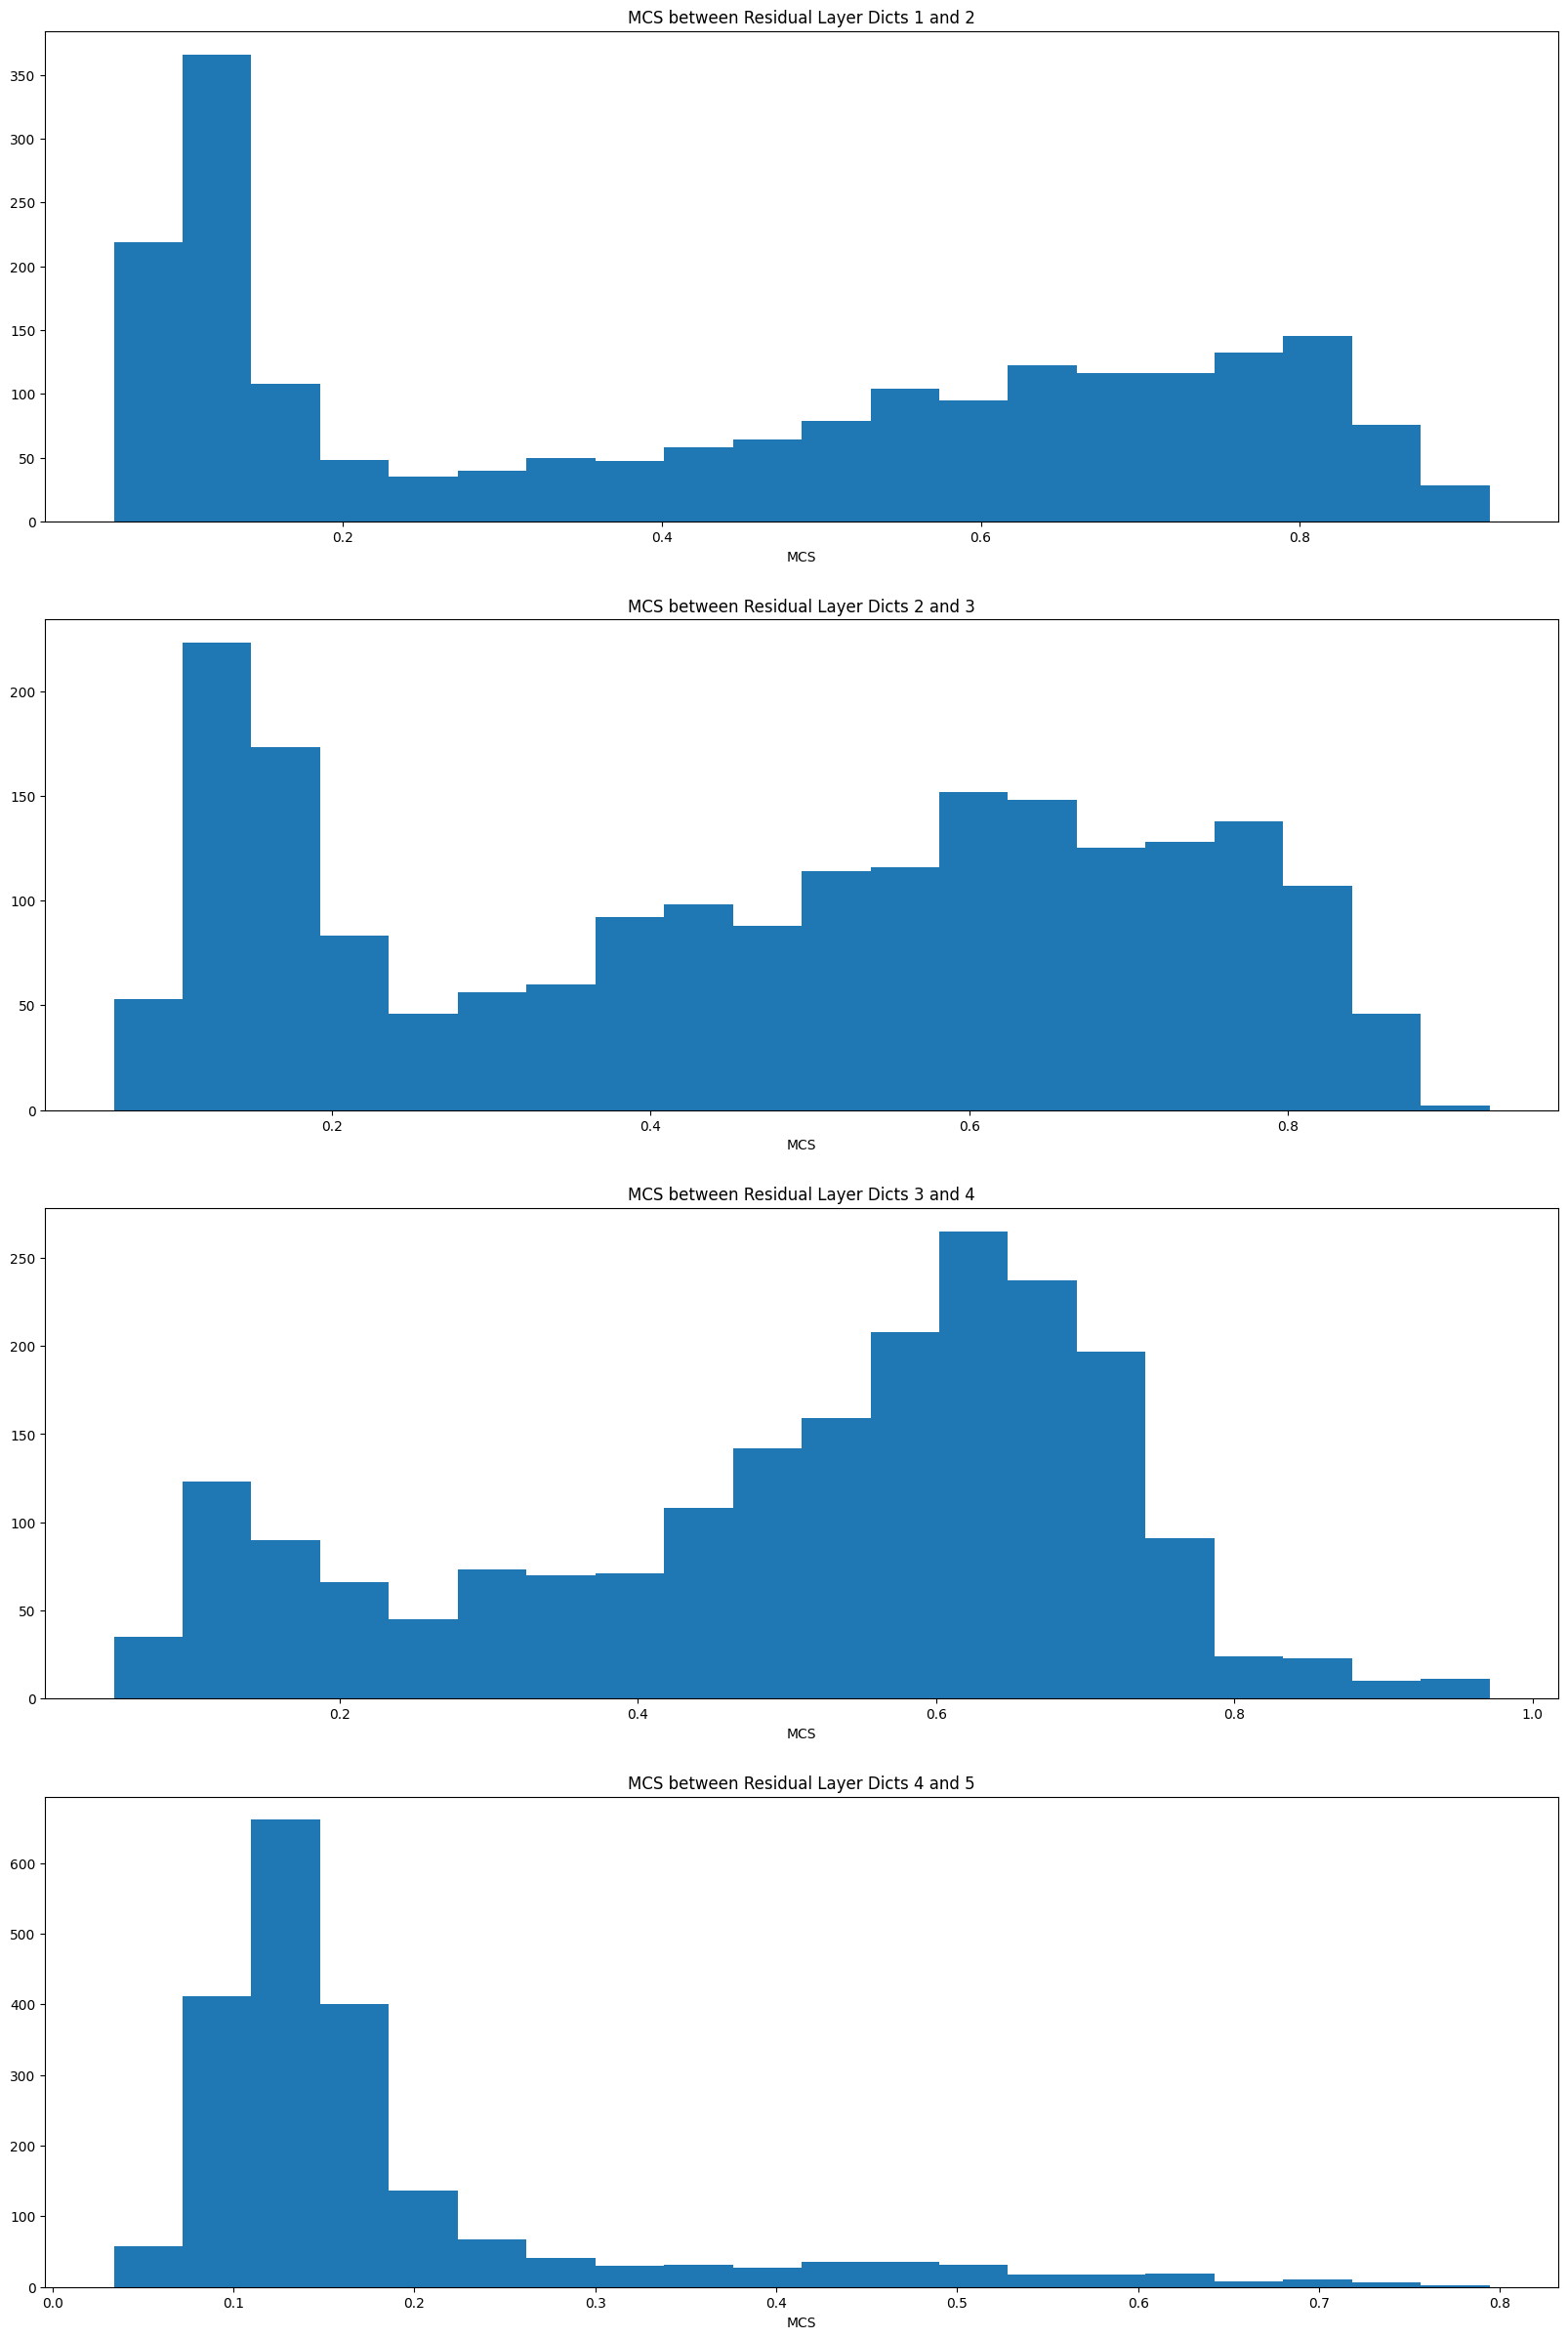

In [11]:
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
# Loop through the dictionaries in dictionaries
fig, axs = plt.subplots(4, figsize=(20, 30))

for i in range(len(dictionaries)-1):
    smaller_dict, larger_dict = dictionaries[i], dictionaries[i+1]

    #Dictionary Comparison
    smaller_dict_features, _ = smaller_dict.shape
    larger_dict_features, _ = larger_dict.shape
    larger_dict = larger_dict.to(device)
    # Hungary algorithm
    # Calculate all cosine similarities and store in a 2D array
    cos_sims = np.zeros((smaller_dict_features, larger_dict_features))
    for idx, vector in enumerate(smaller_dict):
        cos_sims[idx] = torch.nn.functional.cosine_similarity(vector.to(device), larger_dict, dim=1).cpu().numpy()
    # Convert to a minimization problem
    cos_sims = 1 - cos_sims
    # Use the Hungarian algorithm to solve the assignment problem
    row_ind, col_ind = linear_sum_assignment(cos_sims)
    # Retrieve the max cosine similarities and corresponding indices
    max_cosine_similarities = 1 - cos_sims[row_ind, col_ind]

    # Get the indices of the max cosine similarities in descending order
    max_indices = np.argsort(max_cosine_similarities)[::-1]
    max_cosine_similarities[max_indices][:20]
    print(("# of features above 0.9:", (max_cosine_similarities > .9).sum()))

    # Plot histogram of max_cosine_similarities
    axs[i].hist(max_cosine_similarities, bins=20)
    axs[i].set_title(f"MCS between Residual Layer Dicts {i+1} and {i+2}")
    axs[i].set_xlabel("MCS")
plt.show()

Across dictionaries of same Layer for MCS

('# of features above 0.9:', 1447)
('# of features above 0.9:', 929)
('# of features above 0.9:', 1410)
('# of features above 0.9:', 1354)
('# of features above 0.9:', 85)


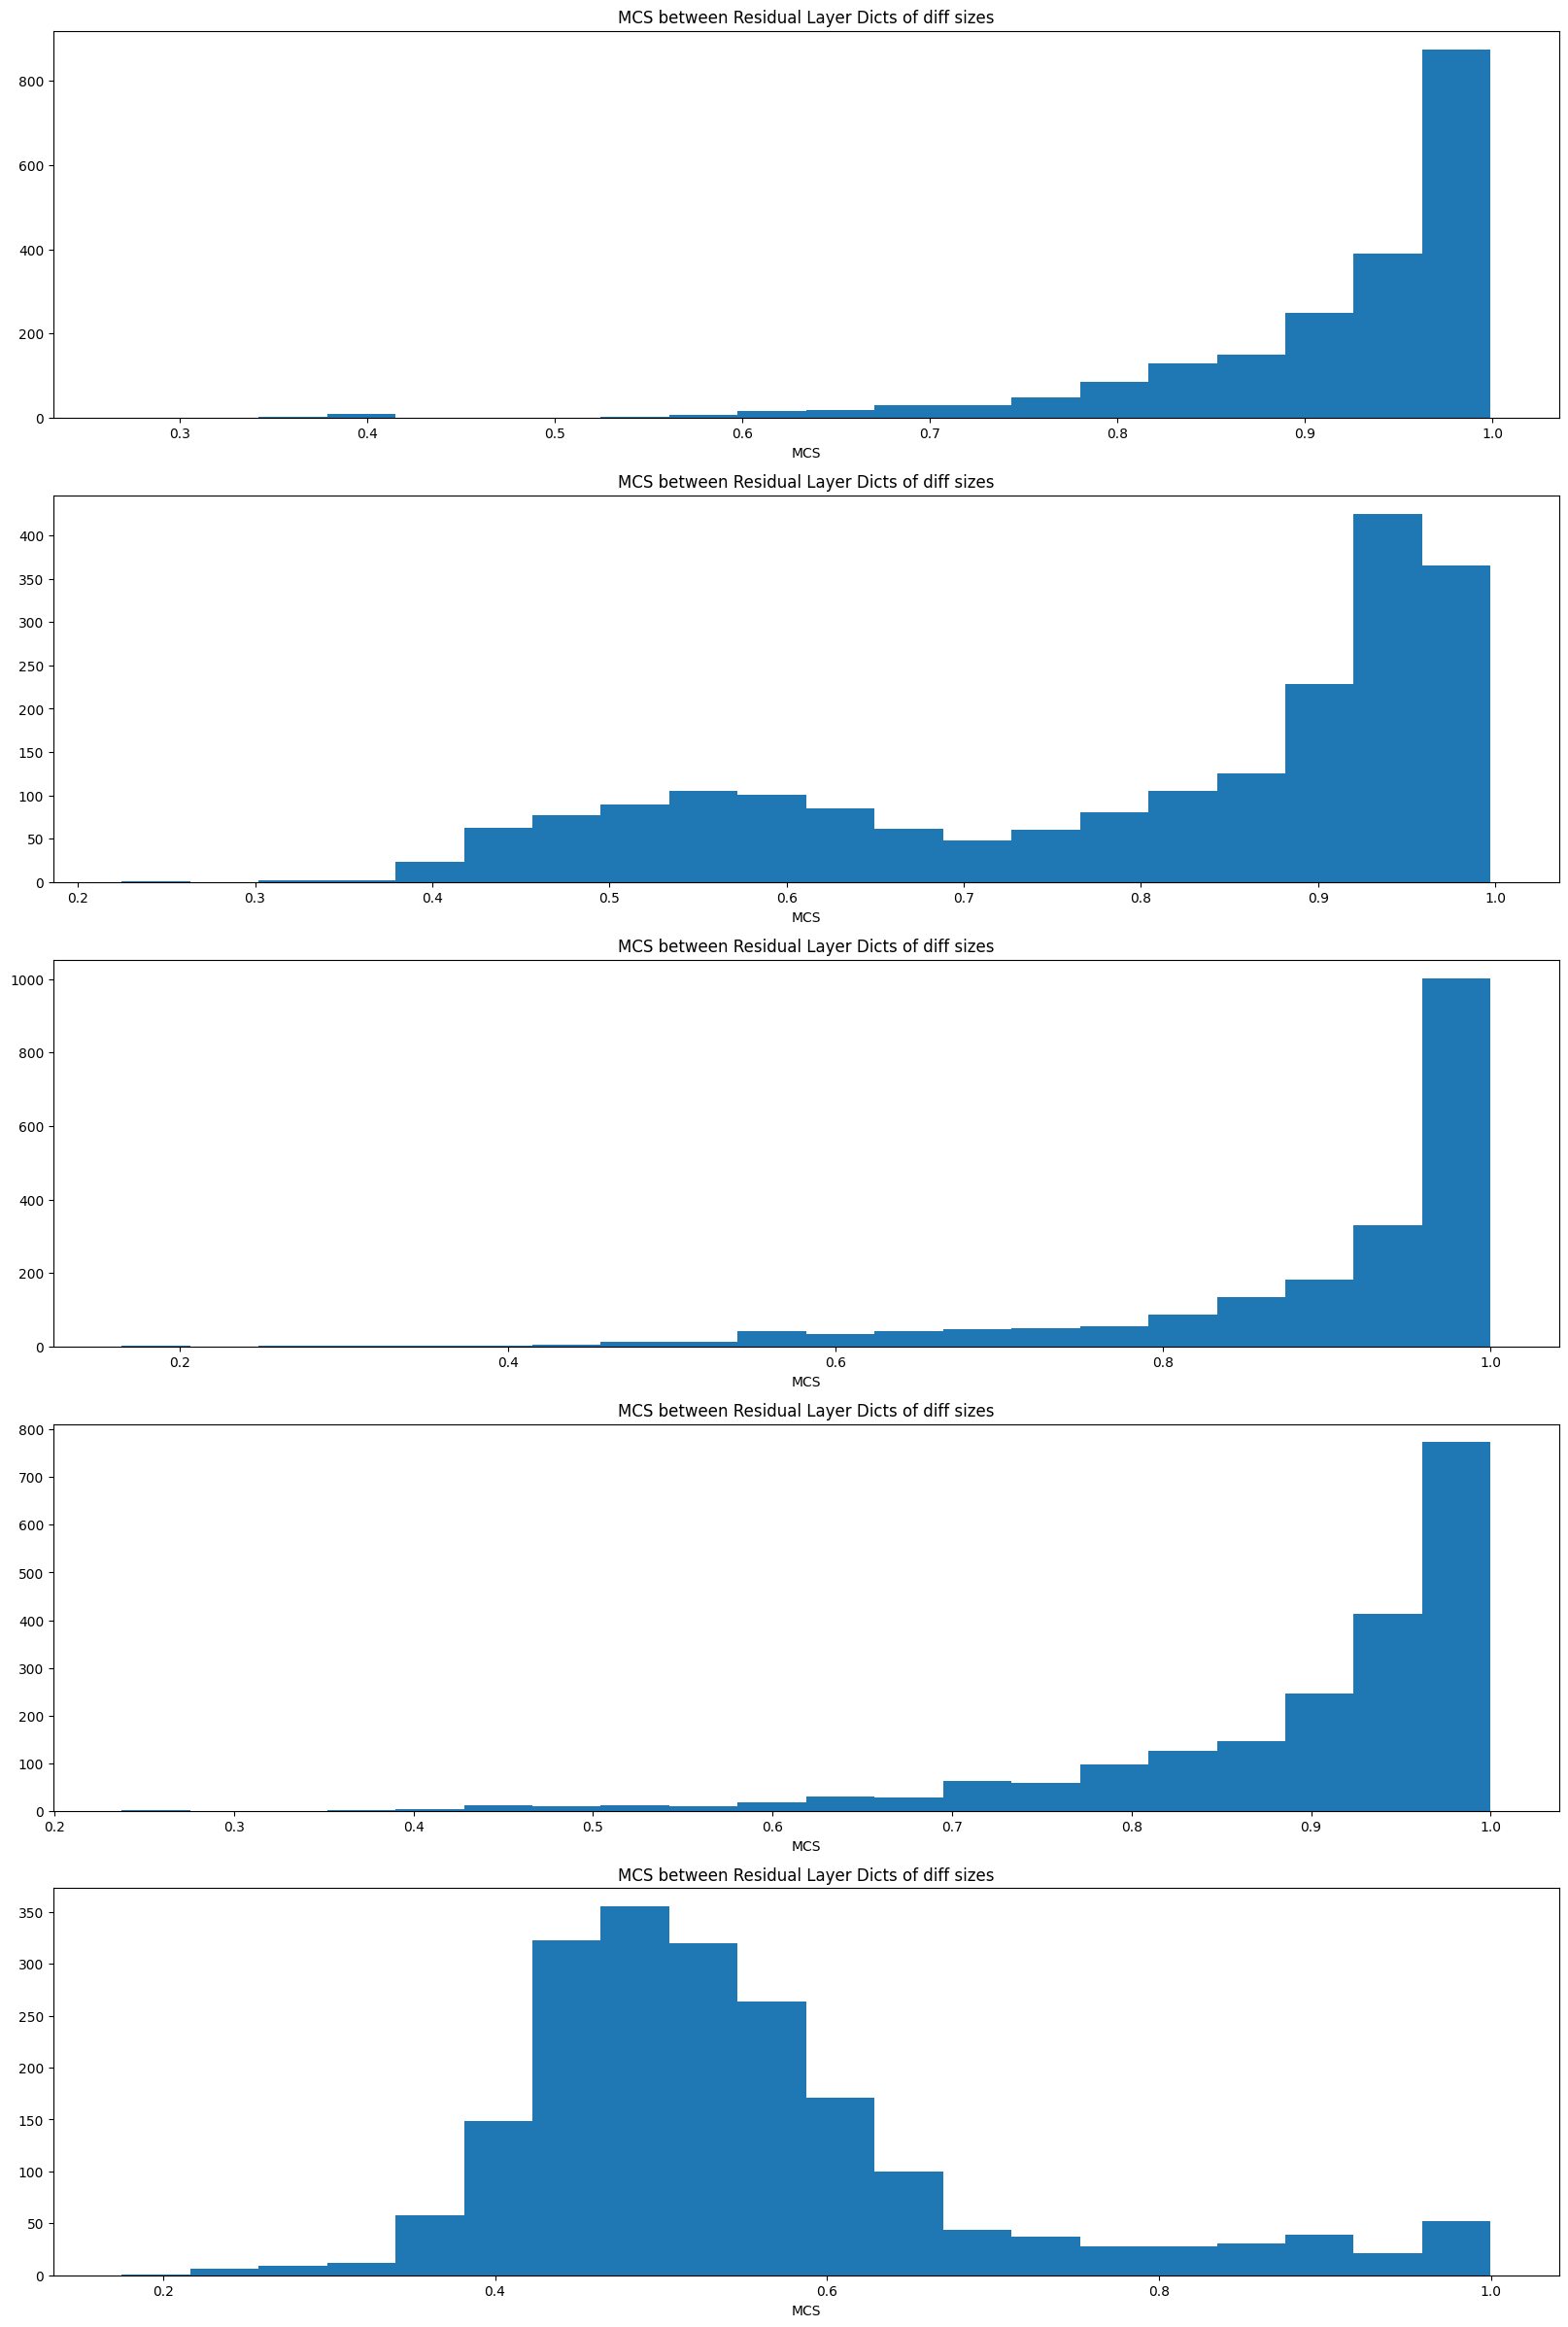

In [12]:
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
# Loop through the dictionaries in dictionaries
fig, axs = plt.subplots(5, figsize=(20, 30))
max_indices = []
for i in range(len(dictionaries)):
    smaller_dict, larger_dict = dictionaries[i], dictionaries_2[i]

    #Dictionary Comparison
    smaller_dict_features, _ = smaller_dict.shape
    larger_dict_features, _ = larger_dict.shape
    larger_dict = larger_dict.to(device)
    # Hungary algorithm
    # Calculate all cosine similarities and store in a 2D array
    cos_sims = np.zeros((smaller_dict_features, larger_dict_features))
    for idx, vector in enumerate(smaller_dict):
        cos_sims[idx] = torch.nn.functional.cosine_similarity(vector.to(device), larger_dict, dim=1).cpu().numpy()
    # Convert to a minimization problem
    cos_sims = 1 - cos_sims
    # Use the Hungarian algorithm to solve the assignment problem
    row_ind, col_ind = linear_sum_assignment(cos_sims)
    # Retrieve the max cosine similarities and corresponding indices
    max_cosine_similarities = 1 - cos_sims[row_ind, col_ind]

    # Get the indices of the max cosine similarities in descending order
    select_max_indices = np.argsort(max_cosine_similarities)[::-1]
    max_indices.append(select_max_indices)
    print(("# of features above 0.9:", (max_cosine_similarities > .9).sum()))

    # Plot histogram of max_cosine_similarities
    axs[i].hist(max_cosine_similarities, bins=20)
    axs[i].set_title(f"MCS between Residual Layer Dicts of diff sizes")
    axs[i].set_xlabel("MCS")
plt.show()

# Model activations & Dictionary Activations

In [13]:
# Downnload dataset
from datasets import Dataset, load_dataset
dataset_name = "NeelNanda/pile-10k"
token_amount= 30
dataset = load_dataset(dataset_name, split="train[:4000]").map(
    lambda x: model.tokenizer(x['text']),
    batched=True,
).filter(
    lambda x: len(x['input_ids']) > token_amount
).map(
    lambda x: {'input_ids': x['input_ids'][:token_amount]}
)

Found cached dataset parquet (/home/mchorse/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [14]:
# Now we can use the model to get the activations
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from einops import rearrange
# neurons = model.W_in.shape[-1]
neurons = model.cfg.d_model
datapoints = dataset.num_rows
batch_size = 32
all_dict_activations = []
all_neuron_activations = []

with torch.no_grad(), dataset.formatted_as("pt"):
    dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for layer in layers:
        neuron_activations = torch.zeros((datapoints*token_amount, neurons))
        dictionary_activations = torch.zeros((datapoints*token_amount, smaller_dict_features))
        for i, batch in enumerate(tqdm(dl)):
            _, cache = model.run_with_cache(batch.to(device))
            current_autoencoder = autoencoders[layer-1].to(device)
            cache_name = f"blocks.{layer}.hook_resid_post"
            batched_neuron_activations = rearrange(cache[cache_name], "b s n -> (b s) n" )
            neuron_activations[i*batch_size*token_amount:(i+1)*batch_size*token_amount,:] = batched_neuron_activations.cpu()
            _, batched_dictionary_activations = current_autoencoder(batched_neuron_activations)
            dictionary_activations[i*batch_size*token_amount:(i+1)*batch_size*token_amount,:] = batched_dictionary_activations.cpu()
        all_dict_activations.append(dictionary_activations)
        all_neuron_activations.append(neuron_activations)

  0%|          | 0/124 [00:00<?, ?it/s]

100%|██████████| 124/124 [00:02<00:00, 56.58it/s]


# Feature Activation Analysis

## Useful Functions

In [15]:
from circuitsvis.activations import text_neuron_activations
# Get the activations for the best dict features
def get_feature_datapoints(feature_index, dictionary_activations, dataset, k=10, setting="max"):
    best_feature_activations = dictionary_activations[:, feature_index]
    # Sort the features by activation, get the indices
    if setting=="max":
        found_indices = torch.argsort(best_feature_activations, descending=True)[:k]
    elif setting=="uniform":
        # min_value = torch.min(best_feature_activations)
        min_value = torch.min(best_feature_activations)
        max_value = torch.max(best_feature_activations)

        # Define the number of bins
        num_bins = k

        # Calculate the bin boundaries as linear interpolation between min and max
        bin_boundaries = torch.linspace(min_value, max_value, num_bins + 1)

        # Assign each activation to its respective bin
        bins = torch.bucketize(best_feature_activations, bin_boundaries)

        # Initialize a list to store the sampled indices
        sampled_indices = []

        # Sample from each bin
        for bin_idx in torch.unique(bins):
            if(bin_idx==0): # Skip the first one. This is below the median
                continue
            # Get the indices corresponding to the current bin
            bin_indices = torch.nonzero(bins == bin_idx, as_tuple=False).squeeze(dim=1)
            
            # Randomly sample from the current bin
            sampled_indices.extend(np.random.choice(bin_indices, size=1, replace=False))

        # Convert the sampled indices to a PyTorch tensor & reverse order
        found_indices = torch.tensor(sampled_indices).long().flip(dims=[0])
    else: # random
        # get nonzero indices
        nonzero_indices = torch.nonzero(best_feature_activations)[:, 0]
        # shuffle
        shuffled_indices = nonzero_indices[torch.randperm(nonzero_indices.shape[0])]
        found_indices = shuffled_indices[:k]
    datapoint_indices =[np.unravel_index(i, (datapoints, token_amount)) for i in found_indices]
    text_list = []
    full_text = []
    token_list = []
    full_token_list = []
    for md, s_ind in datapoint_indices:
        md = int(md)
        s_ind = int(s_ind)
        full_tok = torch.tensor(dataset[md]["input_ids"])
        full_text.append(model.tokenizer.decode(full_tok))
        tok = dataset[md]["input_ids"][:s_ind+1]
        text = model.tokenizer.decode(tok)
        text_list.append(text)
        token_list.append(tok)
        full_token_list.append(full_tok)
    return text_list, full_text, token_list, full_token_list

def get_neuron_activation(token, feature, model, autoencoder, layer, setting="dictionary_basis"):
    with torch.no_grad():
        _, cache = model.run_with_cache(token.to(model.cfg.device))
        cache_name = f"blocks.{layer}.hook_resid_post"
        neuron_act_batch = cache[cache_name]
        if setting=="dictionary_basis":
            _, act = autoencoder(neuron_act_batch)
            return act[0, :, feature].tolist()
        else: # neuron/residual basis
            return neuron_act_batch[0, :, feature].tolist()

def ablate_text(text, feature, model, autoencoder, layer,  setting="plot"):
    if isinstance(text, str):
        text = [text]
    display_text_list = []
    activation_list = []
    for t in text:
        # Convert text into tokens
        if isinstance(t, str): # If the text is a list of tokens
            split_text = model.to_str_tokens(t, prepend_bos=False)
            tokens = model.to_tokens(t, prepend_bos=False)
        else: # t equals tokens
            tokens = t
            split_text = model.to_str_tokens(t, prepend_bos=False)
        seq_size = tokens.shape[1]
        if(seq_size == 1): # If the text is a single token, we can't ablate it
            continue
        original = get_neuron_activation(tokens, feature, model, autoencoder, layer)[-1]
        changed_activations = torch.zeros(seq_size, device=device).cpu()
        for i in range(seq_size):
            # Remove the i'th token from the input
            ablated_tokens = torch.cat((tokens[:,:i], tokens[:,i+1:]), dim=1)
            changed_activations[i] += get_neuron_activation(ablated_tokens, feature, model, autoencoder, layer)[-1]
        changed_activations -= original
        display_text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
        activation_list += changed_activations.tolist() + [0.0]
    activation_list = torch.tensor(activation_list).reshape(-1,1,1)
    if setting == "plot":
        return text_neuron_activations(tokens=display_text_list, activations=activation_list)
    else:
        return display_text_list, activation_list
        
def visualize_text(text, feature, model,autoencoder, layer, setting="dictionary_basis", max_activation = None):
    if isinstance(text, str):
        text = [text]
    if isinstance(feature, int):
        feature = [feature]
    display_text_list = []
    act_list = []
    for t in text:
        if isinstance(t, str): # If the text is a list of tokens
            split_text = model.to_str_tokens(t, prepend_bos=False)
            token = model.to_tokens(t, prepend_bos=False)
        else: # t are tokens
            token = t
            split_text = model.to_str_tokens(t, prepend_bos=False)
        for f in feature:
            display_text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
            act_list += get_neuron_activation(token, f, model, autoencoder, layer, setting) + [0.0]
    act_list = torch.tensor(act_list).reshape(-1,1,1)
    if(max_activation is not None):
        act_list = torch.clamp(act_list, max=max_activation)
    return text_neuron_activations(tokens=display_text_list, activations=act_list)
# Ablate the feature direction of the tokens
# token_list is a list of tokens, convert to tensor of shape (batch_size, seq_len)
from einops import rearrange
def ablate_feature_direction(tokens, feature, model, autoencoder, layer):
    def mlp_ablation_hook(value, hook):
        # Rearrange to fit autoencoder
        int_val = rearrange(value, 'b s h -> (b s) h')

        # Run through the autoencoder
        _, act = autoencoder(int_val)
        feature_to_ablate = feature # TODO: bring this out of the function

        # Subtract value with feature direction*act_of_feature
        feature_direction = torch.outer(act[:, feature_to_ablate].squeeze(), autoencoder.decoder.weight[:, feature_to_ablate].squeeze())
        batch, seq_len, hidden_size = value.shape
        feature_direction = rearrange(feature_direction, '(b s) h -> b s h', b=batch, s=seq_len)
        value -= feature_direction
        return value
    
    cache_name = f"blocks.{layer}.hook_resid_post"
    return model.run_with_hooks(tokens, 
        fwd_hooks=[(
            cache_name, 
            mlp_ablation_hook
            )]
        )
def add_feature_direction(tokens, feature, model, autoencoder, scalar=1.0):
    def residual_add_hook(value, hook):
        feature_direction = autoencoder.decoder.weight[:, feature].squeeze()
        value += scalar*feature_direction
        return value

    return model.run_with_hooks(tokens, 
        fwd_hooks=[(
            cache_name,
            residual_add_hook
            )]
        )
def ablate_feature_direction_display(text, autoencoder,layer, features=None, setting="true_tokens", verbose=False):

    if features==None:
        features = torch.tensor([best_feature])
    if isinstance(features, int):
        features = torch.tensor([features])
    if isinstance(features, list):
        features = torch.tensor(features)
    if isinstance(text, str):
        text = [text]
    text_list = []
    logit_list = []
    for t in text:
        tokens = model.to_tokens(t, prepend_bos=False)
        with torch.no_grad():
            original_logits = model(tokens).log_softmax(-1).cpu()
            ablated_logits = ablate_feature_direction(tokens, features, model, autoencoder, layer).log_softmax(-1).cpu()
        diff_logits = ablated_logits  - original_logits# ablated > original -> negative diff
        tokens = tokens.cpu()
        if setting == "true_tokens":
            split_text = model.to_str_tokens(t, prepend_bos=False)
            gather_tokens = rearrange(tokens[:,1:], "b s -> b s 1") # TODO: verify this is correct
            # Gather the logits for the true tokens
            diff = rearrange(diff_logits[:, :-1].gather(-1,gather_tokens), "b s n -> (b s n)")
        elif setting == "max":
            # Negate the diff_logits to see which tokens have the largest effect on the neuron
            val, ind = (-1*diff_logits).max(-1)
            diff = rearrange(val[:, :-1], "b s -> (b s)")
            diff*= -1 # Negate the values gathered
            split_text = model.to_str_tokens(ind, prepend_bos=False)
            gather_tokens = rearrange(ind[:,1:], "1 s -> 1 s 1")
        split_text = split_text[1:] # Remove the first token since we're not predicting it
        if(verbose):
            text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
            text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
            orig = rearrange(original_logits[:, :-1].gather(-1, gather_tokens), "b s n -> (b s n)")
            ablated = rearrange(ablated_logits[:, :-1].gather(-1, gather_tokens), "b s n -> (b s n)")
            logit_list += orig.tolist() + [0.0]
            logit_list += ablated.tolist() + [0.0]
        text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
        logit_list += diff.tolist() + [0.0]
    logit_list = torch.tensor(logit_list).reshape(-1,1,1)
    if verbose:
        print(f"Max & Min logit-diff: {logit_list.max().item():.2f} & {logit_list.min().item():.2f}")
    return text_neuron_activations(tokens=text_list, activations=logit_list)

def generate_text(input_text, num_tokens, model, autoencoder, feature, temperature=0.7, setting="add", scalar=1.0):
    # Convert input text to tokens
    input_ids = model.tokenizer.encode(input_text, return_tensors='pt').to(device)

    for _ in range(num_tokens):
        # Generate logits
        with torch.no_grad():
            if(setting=="add"):
                logits = add_feature_direction(input_ids, feature, model, autoencoder, scalar=scalar)
            else:
                logits = model(input_ids)

        # Apply temperature
        logits = logits / temperature

        # Sample from the distribution
        probs = torch.nn.functional.softmax(logits[:, -1, :], dim=-1)
        predicted_token = torch.multinomial(probs, num_samples=1)

        # Append predicted token to input_ids
        input_ids = torch.cat((input_ids, predicted_token), dim=-1)

    # Decode the tokens to text
    output_text = model.tokenizer.decode(input_ids[0])

    return output_text

# Logit Lens
def logit_lens(model, best_feature, dictionary, layer):
    with torch.no_grad():
        # There are never-used tokens, which have high norm. We want to ignore these.
        bad_ind = (model.W_U.norm(dim=0) > 20)
        feature_direction = dictionary[best_feature].to(device)
        # feature_direction = torch.matmul(feature_direction, model.W_out[layer]) # if MLP
        logits = torch.matmul(feature_direction, model.W_U).cpu()
    # Don't include bad indices
    logits[bad_ind] = -1000
    topk_values, topk_indices = torch.topk(logits, 20)
    top_text = model.to_str_tokens(topk_indices)
    print(f"{top_text}")
    print(topk_values)


In [16]:
from functools import partial
# Ablate feature direction for all features in layer 4, see how they effect feature 325 in layer 5
# Get datapoints that activate our given feature

def find_causal_features(target_feature, target_layer,previous_layer,  k=10, setting="ablate", data_setting="max"):
    target_layer_dict_activations = all_dict_activations[target_layer-1][:, target_feature]
    # non_zero_activations = torch.nonzero(target_layer_dict_activations[:, target_feature]).squeeze()
    # Instead, get the top-10 activations
    if(data_setting=="max"):    
        non_zero_values, non_zero_indices = torch.topk(target_layer_dict_activations, k)
    else:
        max_value = torch.max(target_layer_dict_activations)
        min_value = torch.min(target_layer_dict_activations)
        min_value = (max_value - min_value) * 0.5

        # Define the number of bins
        num_bins = k

        # Calculate the bin boundaries as linear interpolation between min and max
        bin_boundaries = torch.linspace(min_value, max_value, num_bins + 1)

        # Assign each activation to its respective bin
        bins = torch.bucketize(target_layer_dict_activations, bin_boundaries)

        # Initialize a list to store the sampled indices
        sampled_indices = []

        # Sample from each bin
        for bin_idx in torch.unique(bins):
            if(bin_idx==0): # Skip the first one. This is below the median
                continue
            # Get the indices corresponding to the current bin
            bin_indices = torch.nonzero(bins == bin_idx, as_tuple=False).squeeze(dim=1)            
            # Randomly sample from the current bin
            sampled_indices.extend(np.random.choice(bin_indices, size=1, replace=False))

        # Convert the sampled indices to a PyTorch tensor & reverse order
        non_zero_indices = torch.tensor(sampled_indices).long().flip(dims=[0])
        non_zero_values = target_layer_dict_activations[non_zero_indices]
    non_zero_values, non_zero_indices
    datapoint_indices = [np.unravel_index(i, (datapoints, token_amount)) for i in non_zero_indices]
    token_list = []

    max_activating_token_positions = []
    for datapoint_index, max_activating_token_pos in datapoint_indices:
        datapoint_index = int(datapoint_index)
        max_activating_token_pos = int(max_activating_token_pos)
        tok = dataset[datapoint_index]["input_ids"][:max_activating_token_pos+1]
        token_list.append(tok)
        max_activating_token_positions.append(max_activating_token_pos)
    max_len = max(len(seq) for seq in token_list)

    # Pad all sequences to the length of the longest sequence
    padded_sequences = torch.tensor([seq + [model.tokenizer.pad_token_id] * (max_len - len(seq)) for seq in token_list])

    def ablate_feature_direction_hook(value, hook, feature_to_ablate):
        # Rearrange to fit autoencoder
        int_val = rearrange(value, 'b s h -> (b s) h')

        # Run through the autoencoder
        _, act = autoencoders[previous_layer-1](int_val)
        
        # Subtract value with feature direction*act_of_feature
        feature_direction = torch.outer(act[:, feature_to_ablate].squeeze(), autoencoders[previous_layer-1].decoder.weight[:, feature_to_ablate].squeeze())
        batch, seq_len, hidden_size = value.shape
        feature_direction = rearrange(feature_direction, '(b s) h -> b s h', b=batch, s=seq_len)
        value -= feature_direction
        return value

    def restore_feature_direction_hook(value, hook, feature_to_restore):
        # Rearrange to fit autoencoder
        int_val = rearrange(value, 'b s h -> (b s) h')

        # Run through the autoencoder
        _, act = autoencoders[previous_layer-1](int_val)
        
        
        # Subtract value with feature direction*act_of_feature
        feature_direction = torch.outer(act[:, feature_to_restore].squeeze(), autoencoders[previous_layer-1].decoder.weight[:, feature_to_restore].squeeze())
        batch, seq_len, hidden_size = value.shape
        feature_direction = rearrange(feature_direction, '(b s) h -> b s h', b=batch, s=seq_len)
        value *= 0
        value += feature_direction
        return value

    def save_activations_hook(value, hook, setting="ablate"):
        batch_size, seq_size, _ = value.shape
        # Rearrange to fit autoencoder
        int_val = rearrange(value, 'b s h -> (b s) h')
        max_target_pos = [max_activating_token_positions[i] + i*seq_size for i in range(batch_size)]
        # Run through the autoencoder
        _, act = autoencoders[target_layer-1](int_val)
        changed_feature_values = act[max_target_pos, target_feature].cpu()
        if(setting=="ablate"):
            # activations.append((non_zero_values - changed_feature_values).mean().item())
            activations.append(((non_zero_values - changed_feature_values + 1e-10) / (non_zero_values+ 1e-10)).mean().item())
        else:
            activations.append(((changed_feature_values + 1e-10)/(non_zero_values+ 1e-10)).mean().item())
        return value
    
    activations = []
    total_number_of_features = dictionary_activations.shape[1]
    # total_number_of_features = 20
    for feature_to_ablate in range(total_number_of_features):
        if(setting=="ablate"):
            hooks=[(f"blocks.{previous_layer}.hook_resid_post", partial(ablate_feature_direction_hook, feature_to_ablate=feature_to_ablate)), (f"blocks.{target_layer}.hook_resid_post", partial(save_activations_hook, setting=setting))]
        else:
            hooks=[(f"blocks.{previous_layer}.hook_resid_post", partial(restore_feature_direction_hook, feature_to_restore=feature_to_ablate)), (f"blocks.{target_layer}.hook_resid_post", partial(save_activations_hook, setting=setting))]
        with torch.no_grad():
            model.run_with_hooks(padded_sequences, fwd_hooks=hooks)
    return torch.tensor(activations)


/tmp/ipykernel_1833624/634344264.py:23: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:33.)
  bins = torch.bucketize(target_layer_dict_activations, bin_boundaries)


[[325], [1030, 459, 491, 1456, 1527]]
[[325], [1030, 459, 491, 1456, 1527], [1227, 747, 1648, 891, 1407]]
[[325], [1030, 459, 491, 1456, 1527], [1227, 747, 1648, 891, 1407], [808, 714, 46, 184, 989]]
[[325], [1030, 459, 491, 1456, 1527], [1227, 747, 1648, 891, 1407], [808, 714, 46, 184, 989], [1730, 583, 1160, 497, 1749]]


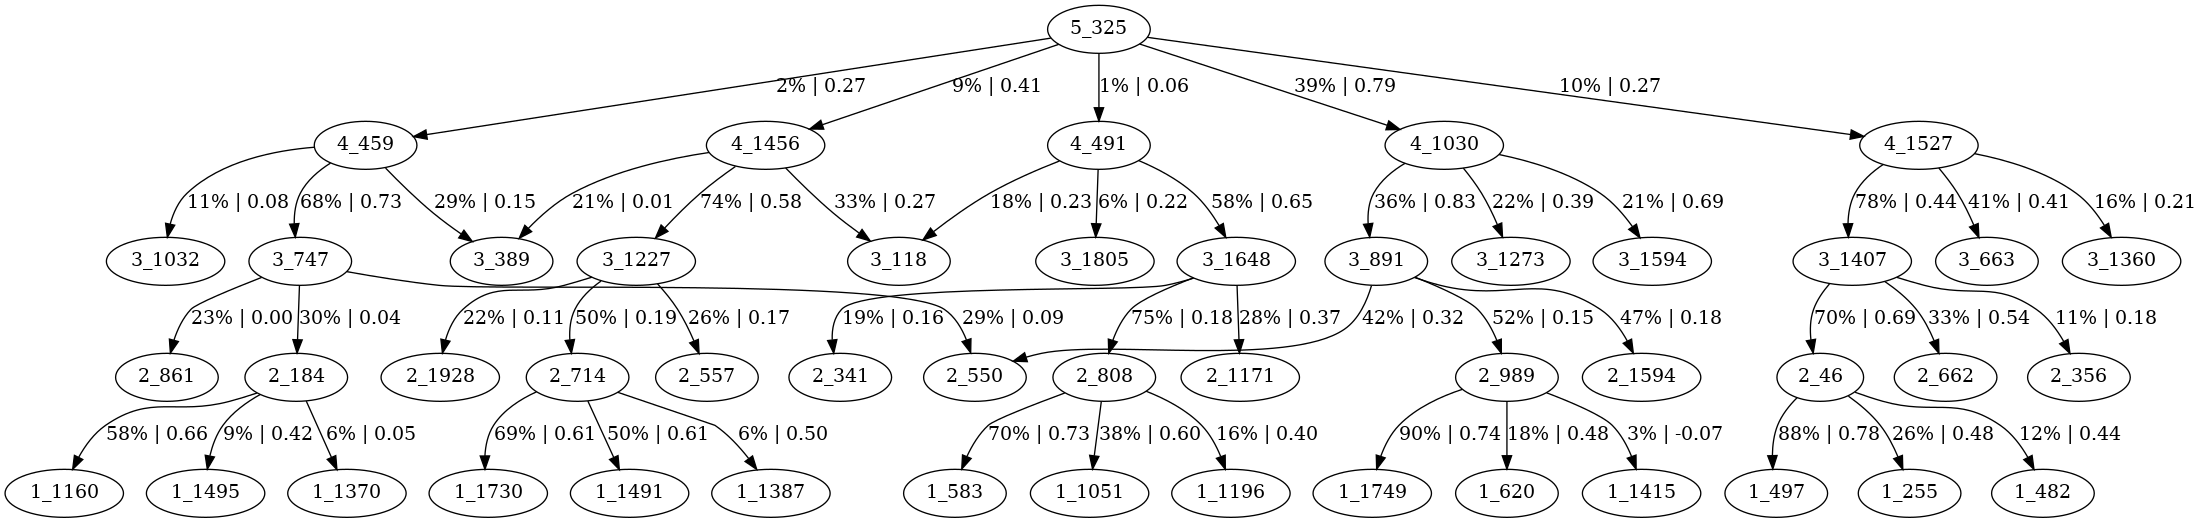

In [17]:
import pygraphviz as pgv
from IPython.display import Image
features_found_in_layers = []
target_feature = 325
target_layer = 5
setting = "ablate"
# setting = "restore"
# data_setting = "max"
data_setting = "median_to_max"
features_found_in_layers.append([target_feature])
num_datapoints_k = 20  # Number of top (or uniform) activating examples to consider when ablating
graph_children_init_k = 5
graph_children_recurse_k= 3

G = pgv.AGraph(directed=True)
for layer in range(target_layer, 1, -1): 
    current_features = []
    for feature in features_found_in_layers[-1]:
        activations = find_causal_features(feature, layer, k=num_datapoints_k, previous_layer=layer-1, setting=setting, data_setting=data_setting)
        if(layer == target_layer):
            values, indices = activations.topk(graph_children_init_k)
            current_features = indices.tolist()
        else:
            values, indices = activations.topk(graph_children_recurse_k)
            current_features.append(indices[0].item())
        for v, i in zip(values, indices):
            # Calculate the CS between the feature and the causal feature
            v1 = dictionaries[layer-1][feature]
            v2 = dictionaries[layer-2][i.item()]
            cs = torch.nn.functional.cosine_similarity(v1, v2, dim=0)
            G.add_edge(f"{layer}_{feature}", f"{layer-1}_{i}", label=f"{int(v.item()*100)}% | {cs.item():.2f}")
    features_found_in_layers.append(list(set(current_features)))
    print(features_found_in_layers)
G.layout(prog="dot")
G.draw('file.png')  # Draws a png

# # Display the graph
Image(filename='file.png')

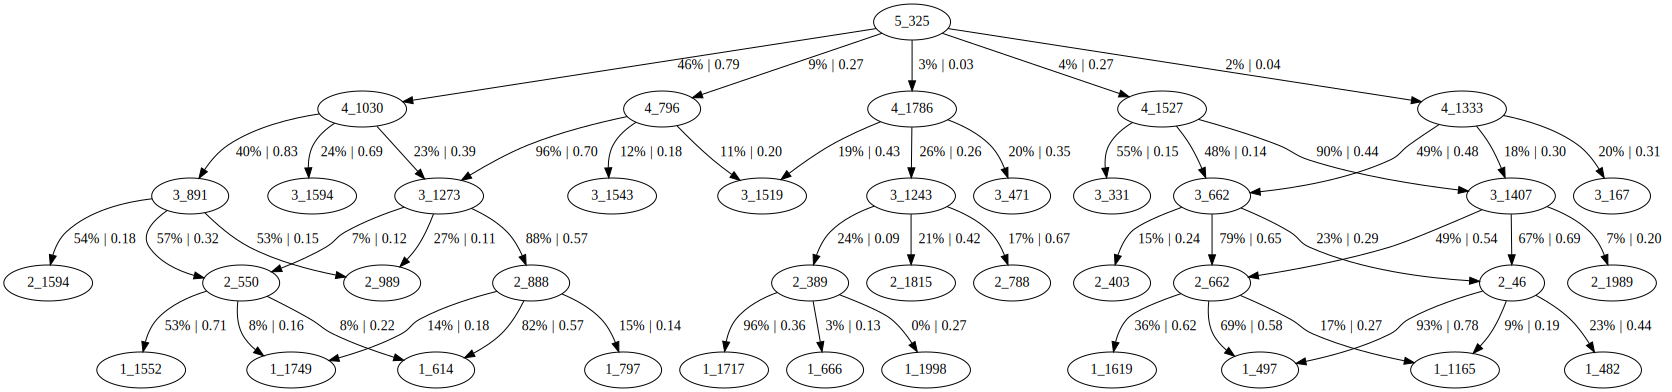

In [ ]:
G

In [ ]:
activations.shape

torch.Size([2048])

In [ ]:
torch.nn.functional.cosine_similarity(v1, v2, dim=0)

tensor(0.1447)

In [ ]:
ind = [[325], [1030, 1333, 1814, 1527, 796], [1273, 662, 1407], [888, 46, 662], [497, 1619, 614]] # ablated
vectors = []
for i in range(len(ind)):
    for j in range(len(ind[i])):
        vectors.append(dictionaries[i][j])
vectors = torch.stack(vectors)

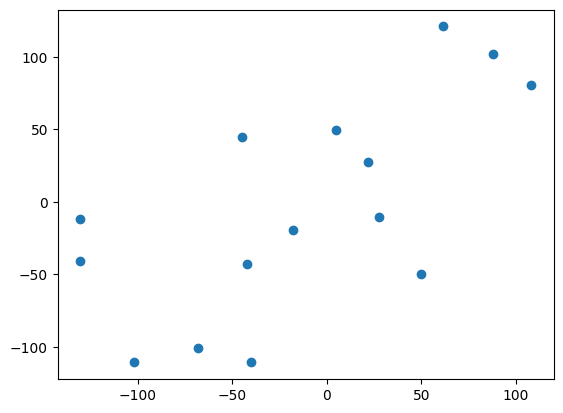

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Run the t-SNE algorithm
tsne = TSNE(n_components=2, random_state=0, perplexity=5)
vectors_2d = tsne.fit_transform(vectors)

# Plot the vectors
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1])
plt.show()

# Feature Interp
Investigate the example sentences the activate this feature.

Max: show max activating (tokens,contexts)

Uniform: Show range of activations from each bin (e.g. sample an example from 1-2, 2-3, etc). 
[Note: if a feature is monosemantic, then the full range of activations should be that feature, not just max-activating ones]

Full_text: shows the full text example

Text_list: shows up to the most activating example (try w/ max activating on a couple of examples to see)

ablate_text: remove the context one token at a time, and show the decrease/increase in activation of that feature

ablate_feature_direction: removes feature direction from model's activation mid-inference, showing the logit diff in the output for every token.

logit_lens: show the logit lens for that feature. If matches ablate_feature_direction, then the computation path is through the residual stream, else, it's through future layers

In [50]:
layer = 4
autoencoder = autoencoders[layer-1].to(device)
dictionary = dictionaries[layer-1]
dictionary_activations = all_dict_activations[layer-1]
select_max_indices = max_indices[layer-1]
# N = 3
# best_feature = int(select_max_indices[N])
# ind=torch.tensor([1030,  796, 1527, 1786, 1814, 1333, 1273, 1946, 1156, 1163])
# ind=torch.tensor([1527, 1814, 1280, 1709,  809, 1786, 1333,  148,  796, 1647])
# ind = [[325], [1030, 1333, 1814, 1527, 796], [1273, 662, 1407], [888, 46, 662], [497, 1619, 614]] # ablated
# ind = [[325], [1280, 1709, 1333, 1814, 1527], [0, 331, 662, 1407], [46, 157, 662, 445], [497, 1466, 435, 1527]] # restored
ind = [[325], [1030, 459, 491, 1456, 1527], [1227, 747, 1648, 891, 1407], [808, 714, 46, 184, 989], [1730, 583, 1160, 497, 1749]]
selected_index = 4
layer_ind = ind[::-1][layer-1]
best_feature = int(layer_ind[selected_index])
# best_feature = 1814
print("bias:", autoencoder.encoder_bias.detach().cpu().numpy()[best_feature])
print(f"Feature index: {best_feature}")
print(f"MCS: {max_cosine_similarities[best_feature]}")
text_list, full_text, token_list, full_token_list = get_feature_datapoints(best_feature, dictionary_activations, dataset, setting="uniform")
# text_list, full_text, token_list, full_token_list = get_feature_datapoints(best_feature, dictionary_activations, dataset, setting="max")
# visualize_text(full_text, best_feature, model, autoencoder, layer)
visualize_text(text_list, best_feature, model, autoencoder, layer)

bias: -1.8048462
Feature index: 1527
MCS: 0.5455871820449829


In [51]:
ablate_text(text_list, best_feature, model, autoencoder, layer)

In [ ]:
# ablate_feature_direction_display(full_text, best_feature, layer)
ablate_feature_direction_display(full_text, autoencoder, layer, features=best_feature)

In [ ]:
logit_lens(model, best_feature, dictionary, layer)

[')|\\', ')-\\', ')+\\', '):=\\', ')=\\', ')={\\', '):=', "')\\", '){\\', ')/\\', ')|^', ')\\|_{', ')}=\\', ')\\,', ')\\', '),\\', ')(\\', ')&', ')+', '),$$']
tensor([2.7841, 2.6917, 2.6218, 2.5237, 2.5082, 2.4395, 2.4210, 2.4074, 2.3755,
        2.3528, 2.3441, 2.3378, 2.3322, 2.2872, 2.2843, 2.2423, 2.2213, 2.2199,
        2.2138, 2.2135])


In [ ]:
t = " I do like a"
split_text = model.to_str_tokens(t, prepend_bos=False)
token = model.to_tokens(t, prepend_bos=False)
_, cache = model.run_with_cache(token.to(model.cfg.device))
neuron_act_batch = cache[cache_name]
_, act = smaller_auto_encoder(neuron_act_batch)
v, i = act[0, -1, :].topk(10)

print("Activations:",[round(val,2) for val in v.tolist()])
print("Feature_ids", i.tolist())

NameError: name 'smaller_auto_encoder' is not defined

In [ ]:
sentence = " for"
temp = 0.7
tokens_to_generate = 20
feature = 10 
scalar = 100.0
# Using the function:
print("Normal:\n" + generate_text(sentence, tokens_to_generate, model, smaller_auto_encoder, feature=feature, temperature=temp, scalar=scalar, setting="normal"))
print("Add:\n" + generate_text(sentence, tokens_to_generate, model, smaller_auto_encoder, feature=feature, temperature=temp, scalar=scalar, setting="add"))

NameError: name 'smaller_auto_encoder' is not defined

In [ ]:
smaller_dict[best_feature].topk(10), smaller_dict[best_feature].topk(10, largest=False)

(torch.return_types.topk(
 values=tensor([0.0197, 0.0193, 0.0117, 0.0088, 0.0077, 0.0074, 0.0065, 0.0064, 0.0061,
         0.0060]),
 indices=tensor([1299,  412,  481,  305, 1887, 1564, 1643,  319,  768, 1488])),
 torch.return_types.topk(
 values=tensor([-0.8940, -0.4320, -0.0470, -0.0292, -0.0127, -0.0119, -0.0102, -0.0081,
         -0.0070, -0.0070]),
 indices=tensor([ 568,  516, 1894,  468, 1326, 1458,  615,  934,  870, 1518])))

In [ ]:
# OUTlier dimensions negative:
#  568,  516, 1894,  468, 1299, 1326,  412, 1458,  934,  615, 1147,  672, 1377, 1518, 1889,  715, 1325,
# outlier dims positive:
# 412,  481,  305, 1894,  319, 1887, 1643, 1876,  801,  615,  362, 1564, 1323,   25,  989, 

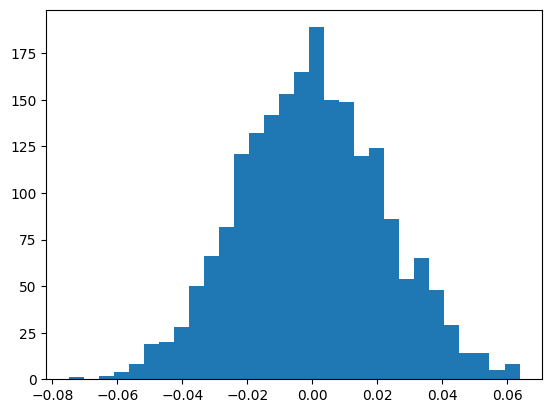

In [ ]:
# Check features non-zero weights in decoder
# Plot a histogram of the weights
weights = smaller_dict[best_feature]
plt.hist(weights, bins=30)
plt.show()

In [ ]:
weights.topk(10, largest=False)

torch.return_types.topk(
values=tensor([-0.8940, -0.4320, -0.0470, -0.0292, -0.0127, -0.0119, -0.0102, -0.0081,
        -0.0070, -0.0070]),
indices=tensor([ 568,  516, 1894,  468, 1326, 1458,  615,  934,  870, 1518]))

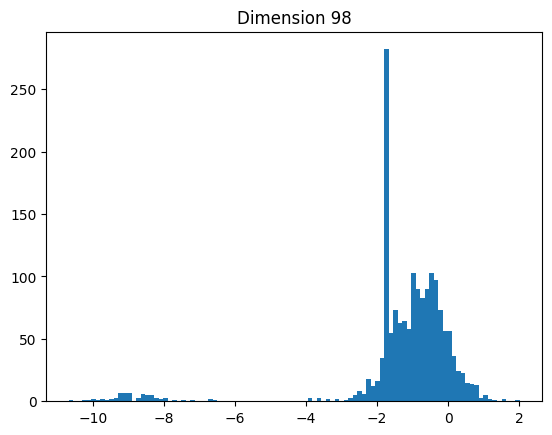

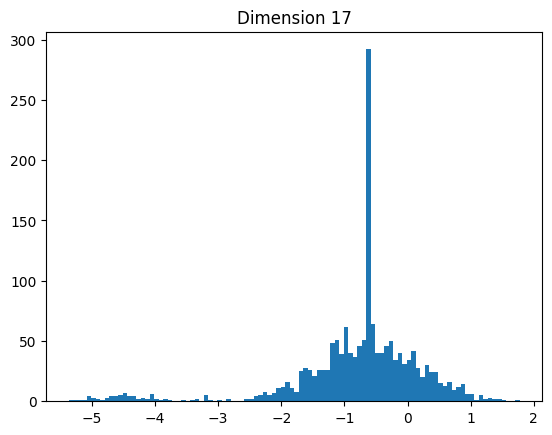

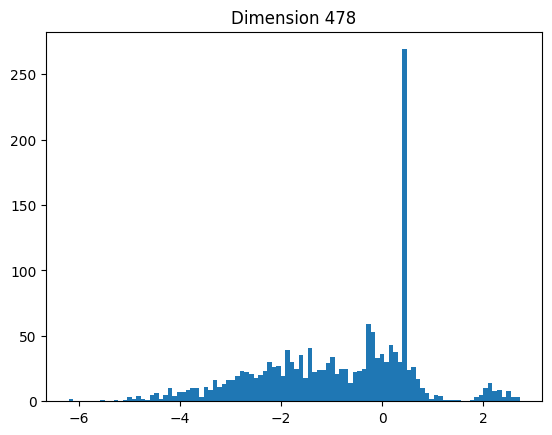

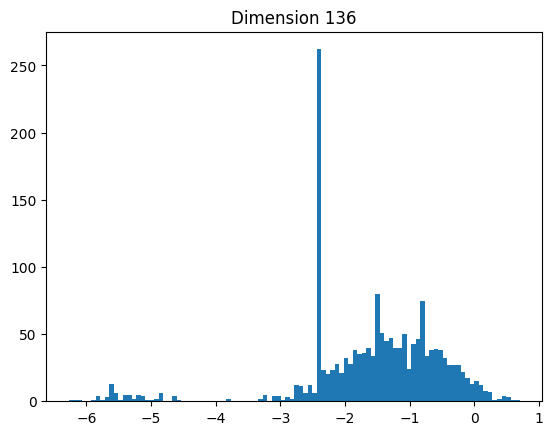

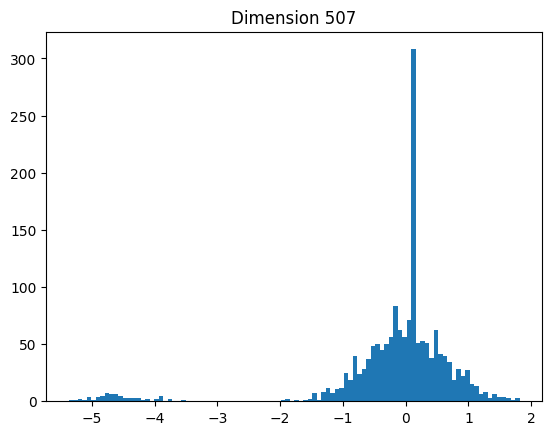

In [ ]:
# Replicate activation of position
# plot as hist
import matplotlib.pyplot as plt
for i in range(5):
    # make new fig
    plt.figure()
    act = neuron_activations[3:100000:token_amount, outlier_dimension.indices[i]]
    plt.title(f"Dimension {outlier_dimension.indices[i]}")
    plt.hist(act, bins=100)
# plt.show()

In [35]:
import numpy as np
from collections import Counter
# For the outlier values that aren't first position, what are the tokens?
# Find index of outlier values that aren't first position
for di in all_dict_activations:
    outlier_dimensions = di.max(dim=0).values.topk(10)
    for i in range(5):
        outlier_indices = torch.where(di[:10000, outlier_dimensions.indices[i]] > 0)[0]
        # Only do first indice now
        outlier_indices = outlier_indices[outlier_indices % token_amount != 0]
        # Find the tokens associated w/ them
        indices = [np.unravel_index(oi, (datapoints, token_amount)) for oi in outlier_indices]
        token_list = []    
        for md, s_ind in indices:
            md = int(md)
            s_ind = int(s_ind)
            tok = dataset[md]["input_ids"][s_ind]
            token_list.append(model.tokenizer.decode(tok))
        token_list
        # Count the unique occurrences of the tokens
        Counter(token_list)
        print(f"{i} {Counter(token_list)}")

0 Counter({'\n': 541, '.': 161, ' the': 140, ',': 96, ' a': 84, ':': 78, ' is': 61, ' and': 55, ' of': 45, ' in': 41, 'I': 30, 'The': 28, ' (': 24, ' I': 20, ' was': 19, '?': 19, ' with': 19, ' have': 17, ' for': 17, ' to': 16, ' on': 15, '’': 14, ' this': 12, ' your': 11, ' are': 11, ' an': 10, ' The': 10, 's': 10, ' relates': 10, ' has': 9, "'s": 9, ' my': 9, ' it': 9, 'This': 9, ' invention': 9, 'In': 8, "'m": 8, ' that': 8, ' by': 7, '-': 7, ' new': 6, ' "': 6, ' our': 6, ' P': 6, ' present': 6, 'Is': 6, ' we': 5, ' file': 5, 'To': 5, ' am': 5, ' article': 5, ' using': 5, ')': 5, ' 2': 5, ' K': 5, 'A': 5, 'ia': 5, ' C': 5, ' create': 5, 'ers': 5, " '": 5, ' S': 4, ' were': 4, ' you': 4, ' term': 4, ' R': 4, ' currently': 4, '...': 4, '!': 4, ' analysis': 4, ' study': 4, "'ve": 4, ' –': 4, ' between': 4, ' -': 4, ' Field': 4, ' Invention': 4, 'How': 4, ' its': 4, ' American': 4, ' D': 4, '<': 4, 'We': 4, 'abstract': 4, '].': 4, ' group': 4, ' F': 3, ' M': 3, ' show': 3, ' can': 3, '

In [33]:
for di in all_dict_activations:
    outlier_dimensions = di.max(dim=0).values.topk(10).indices
    print(outlier_dimensions)

torch.return_types.topk(
values=tensor([31.6288, 13.1711,  7.4994,  7.2150,  7.0181,  6.8310,  6.7971,  6.7736,
         6.7303,  6.6494]),
indices=tensor([1717, 1998, 1314, 1830,  639,  924, 1819, 1602,  923, 1679]))
torch.return_types.topk(
values=tensor([183.5879, 121.1568,  33.1601,  11.9241,   9.3592,   8.1727,   7.2512,
          7.0427,   6.8385,   6.8361]),
indices=tensor([1891,  389, 1958, 1178,  232, 1901, 1896,  206,  200,  989]))
torch.return_types.topk(
values=tensor([220.3352,  28.3979,  22.7274,  18.1072,  16.6322,  15.7106,  14.5732,
         12.1935,   9.4991,   9.3403]),
indices=tensor([1178, 1589,  559, 1417,  902,  766,  882,  588, 1827, 1283]))
torch.return_types.topk(
values=tensor([150.1703,  32.9617,  25.2257,  14.3390,  13.8567,  13.5557,  12.9401,
         12.1904,  11.5138,  11.3889]),
indices=tensor([1891, 1127, 1589, 1391, 1958,  412,  683,  588,  315, 1760]))
torch.return_types.topk(
values=tensor([103.6790,  37.0541,  34.0877,  33.9247,  32.4672,  29.9099

AttributeError: 'list' object has no attribute 'shape'

In [13]:
all_dict_activations[0].shape

torch.Size([118800, 2048])

In [ ]:
dictionary_activations[:, best_feature].count_nonzero().sum() / dictionary_activations.shape[0], dictionary_activations[:, best_feature].count_nonzero(dim=0)

(tensor(0.0654), tensor(37947))

In [ ]:
nz = dictionary_activations.count_nonzero(dim=0)

In [ ]:
nz.median() / dictionary_activations.shape[0]

tensor(0.0008)

In [ ]:
custom_text = [
    "I can count up to: 2 4 8 16 32 64 128 256 512 1024 2048 4096 8192 16384 32768 7 6 12 16 18 20 22 24",
]
visualize_text(custom_text, best_feature, model)

# Data Centric Viewpoint

In [ ]:
# Go through datapoints & see if the features that activate on them make sense.
d_point = 0
# text = tokens_dataset[d_point]
data_ind, sequence_pos = np.unravel_index(d_point, (datapoints, token_amount))
feature_val, feature_ind = dictionary_activations[d_point].topk(10)
data_ind = int(data_ind)
sequence_pos = int(sequence_pos)
full_tok = torch.tensor(dataset[data_ind]["input_ids"])
full_text = []
full_text.append(model.tokenizer.decode(full_tok))
visualize_text(full_text, feature_ind, model)

# Check the neuron/residual basis
When we look at the weights of a feature, we are seeing the literal dimensions from the residual stream/neurons being read from the feature. 

Here I'm visualizing the weight values for the residual stream. If there are outliers, then it's mainly reading from that dimension.

In [ ]:
(weights*max_activation).topk(20), (weights*max_activation).topk(20, largest=False).values, (weights*max_activation > 0.2).sum()

(torch.return_types.topk(
 values=tensor([0.6161, 0.6114, 0.6067, 0.5887, 0.5883, 0.5792, 0.5636, 0.5437, 0.5429,
         0.5255, 0.5244, 0.5211, 0.5182, 0.5153, 0.4998, 0.4976, 0.4894, 0.4885,
         0.4840, 0.4824]),
 indices=tensor([ 371,  481,   42, 1080,  725, 1381, 1745, 1926,  604,  307,  568,   22,
         1508, 1670, 1998,  679, 1081, 1115,  122, 1876])),
 tensor([-0.6566, -0.6534, -0.6292, -0.6198, -0.6115, -0.5850, -0.5844, -0.5834,
         -0.5819, -0.5580, -0.5519, -0.5455, -0.5435, -0.5435, -0.5406, -0.5404,
         -0.5395, -0.5389, -0.5320, -0.5313]),
 tensor(332))

# Prepend/Append tokens
We can iterate over all tokens to check which ones activate a feature a lot to more rigorously test a hypothesis on what a feature means.

Note: I'm literately running the model through all 50k tokens prepended to the text here

In [ ]:
def prepend_all_tokens_and_get_feature_activation(model, minimal_activating_example, feature, setting="prepend"):
    tokens = model.to_tokens(minimal_activating_example, prepend_bos=False)

    # Run through every number up to vocab size
    vocab_size = model.cfg.d_vocab
    batch_size = 256*2 # Define your desired batch size

    dollar_feature_activations = torch.zeros(vocab_size)
    for start in range(0, vocab_size, batch_size):
        end = min(start + batch_size, vocab_size)

        token_prep = torch.arange(start, end).to(device)
        token_prep = token_prep.unsqueeze(1)  # Add a dimension for concatenation

        # 1. Prepend to the tokens
        if setting == "prepend":
            tokens_catted = torch.cat((token_prep, tokens.repeat(end - start, 1)), dim=1).long()
        elif setting == "append":
            tokens_catted = torch.cat((tokens.repeat(end - start, 1), token_prep), dim=1).long()
        else:
            raise ValueError(f"Unknown setting: {setting}")

        # 2. Run through the model
        with torch.no_grad():
            _, cache = model.run_with_cache(tokens_catted.to(device))
            neuron_act_batch = cache[cache_name]
            _, act = smaller_auto_encoder(neuron_act_batch)

        # 3. Get the feature
        dollar_feature_activations[start:end] = act[:, -1, feature].cpu().squeeze()

    k = 20
    k_increasing_val, k_increasing_ind = dollar_feature_activations.topk(k)
    k_decreasing_val, k_decreasing_ind = dollar_feature_activations.topk(k, largest=False)
    if(setting == "prepend"):
        print(f"[token]{minimal_activating_example}")
    elif(setting == "append"):
        print(f"{minimal_activating_example}[token]")
    else:
        raise ValueError(f"Unknown setting: {setting}")
    # Print indices converted to tokens
    print(f"Top-{k} increasing: {model.to_str_tokens(k_increasing_ind)}")
    # Print values
    print(f"Top-{k} increasing: {[f'{val:.2f}' for val in k_increasing_val]}")
    print(f"Top-{k} decreasing: {model.to_str_tokens(k_decreasing_ind)}")
    print(f"Top-{k} decreasing: {[f'{val:.2f}' for val in k_decreasing_val]}")
    print(f"Number of 0 activations: {torch.sum(dollar_feature_activations == 0)}")
    if(setting == "prepend"):
        best_text = "".join(model.to_str_tokens(dollar_feature_activations.argmax()) + [minimal_activating_example])
    else:
        best_text = "".join([minimal_activating_example] + model.to_str_tokens(dollar_feature_activations.argmax()))
    return best_text

best_text = ""
for x in range(3):
    # best_text = prepend_all_tokens_and_get_feature_activation(model, best_text, best_feature, setting="prepend")
    best_text = prepend_all_tokens_and_get_feature_activation(model, best_text, best_feature, setting="append")
# prepend_all_tokens_and_get_feature_activation(model, " for all $", best_feature, setting="prepend")
# prepend_all_tokens_and_get_feature_activation(model, " tree", best_feature, setting="prepend")
# prepend_all_tokens_and_get_feature_activation(model, " tree", best_feature, setting="append")

[token]
Top-20 increasing: ['1', ')', '#', '/', '+', "'", '2', '<|padding|>', '*', '$', '.', ',', '&', '0', '"', '(', '<|endoftext|>', '!', '%', '-']
Top-20 increasing: ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
Top-20 decreasing: ['1', ')', '#', '/', '+', "'", '2', '<|padding|>', '*', '$', '.', ',', '&', '0', '"', '(', '<|endoftext|>', '!', '%', '-']
Top-20 decreasing: ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
Number of 0 activations: 50304
<|endoftext|>[token]
Top-20 increasing: [' motivated', ' daring', ' strained', ' accommodating', ' foregoing', 'erred', ' hopes', 'ought', 'ough', 'uding', ' threatened', ' wanting', 'owing', ' appreciated', ' interested', ' limited', ' wonders', ' nominated', ' welcoming', ' able']
Top-20 increasing: ['5.63', '5.54

In [ ]:
best_text = ""
for x in range(3):
    best_text = prepend_all_tokens_and_get_feature_activation(model, best_text, best_feature, setting="prepend")

[token]
Top-20 increasing: ['1', ')', '#', '/', '+', "'", '2', '<|padding|>', '*', '$', '.', ',', '&', '0', '"', '(', '<|endoftext|>', '!', '%', '-']
Top-20 increasing: ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
Top-20 decreasing: ['1', ')', '#', '/', '+', "'", '2', '<|padding|>', '*', '$', '.', ',', '&', '0', '"', '(', '<|endoftext|>', '!', '%', '-']
Top-20 decreasing: ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
Number of 0 activations: 50304
[token]<|endoftext|>
Top-20 increasing: [' hereto', ' preempt', ' decis', ' investigated', ' across', ' impacting', ' transfected', ' issuing', ' advocated', ' cheaper', ' funded', ' harboring', ' poorer', ' deploying', ' neurolog', ' enrolled', ' corroborated', ' exerted', ' desir', ' promoted']
Top-20 increasing: 

In [ ]:
prepend_all_tokens_and_get_feature_activation(model, " for all $", best_feature, setting="prepend")
# prepend_all_tokens_and_get_feature_activation(model, "The", best_feature, setting="append")
# prepend_all_tokens_and_get_feature_activation(model, " tree", best_feature, setting="append")

[token] for all $
Top-20 increasing: [' transgender', 'Love', ' gay', ' LGBT', ' homosexuality', ' feminist', ' activists', ' feminism', ' linebacker', ' activism', ' homosexual', ' abortion', ' Europese', 'Women', ' lesbian', ' racial', ' Latino', ' undercover', ' Citizens', ' legendary']
Top-20 increasing: ['2.68', '2.65', '2.56', '2.50', '2.49', '2.46', '2.35', '2.34', '2.34', '2.33', '2.33', '2.29', '2.27', '2.26', '2.26', '2.14', '2.07', '2.04', '2.02', '1.99']
Top-20 decreasing: ['1', ')', '#', '/', '+', "'", '2', '<|padding|>', '*', '$', '.', ',', '&', '0', '"', '(', '<|endoftext|>', '!', '%', '-']
Top-20 decreasing: ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
Number of 0 activations: 48712


' transgender for all $'